In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# 读取Excel文件到DataFrame中
df = pd.read_csv('/root/2023mcm/Problem_C_Data_Wordle(1).csv', header=0)

# 反向索引DataFrame
reversed_df = df.iloc[::-1]

# 打印反向排序后的DataFrame
df=reversed_df
# 将日期列转换为时间戳格式
df["Date"] = pd.to_datetime(df["Date"])
# 删除缺失值和重复值
df = df.dropna().drop_duplicates()
percent = df[df.columns[5:]].sum(axis=1)
for column in df.columns[5:]:
    df[column]=df[column]/percent*100
# 判断当前日期为周几，周一为0，依次增加  
df['week']=df['Date'].apply(lambda x:x.weekday())
import matplotlib.pyplot as plt

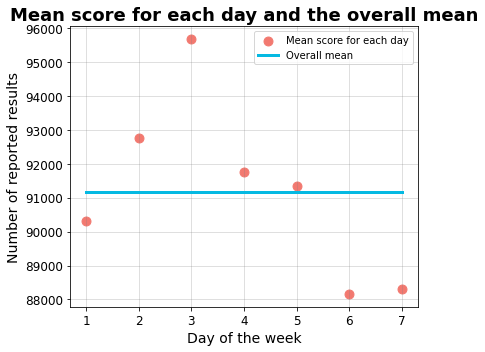

array([[ 1.        , -0.01564205],
       [-0.01564205,  1.        ]])

In [7]:
weeks = []
for week in range(7):
    df1 = df[df['week']==week]
    weeks.append(df1['Number of  reported results'].mean())

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter([i+1 for i in range(7)], weeks, s=80, label='Mean score for each day', color='#F27970')
ax.plot([i+1 for i in range(7)], [df['Number of  reported results'].mean() for i in range(7)], label='Overall mean', color='#05B9E2', linewidth=3)

ax.set_xlabel('Day of the week', fontsize=14)
ax.set_ylabel('Number of reported results', fontsize=14)
ax.set_title('Mean score for each day and the overall mean', fontsize=18, fontweight='bold')
ax.set_xticks([i+1 for i in range(7)])
ax.tick_params(axis='both', which='major', labelsize=12)

# 添加网格
ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
# 减少画面留白
plt.margins(0.05)

ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()
# 整体得分与星期几之间的相关性
np.corrcoef(df['week'], df['Number of  reported results'])

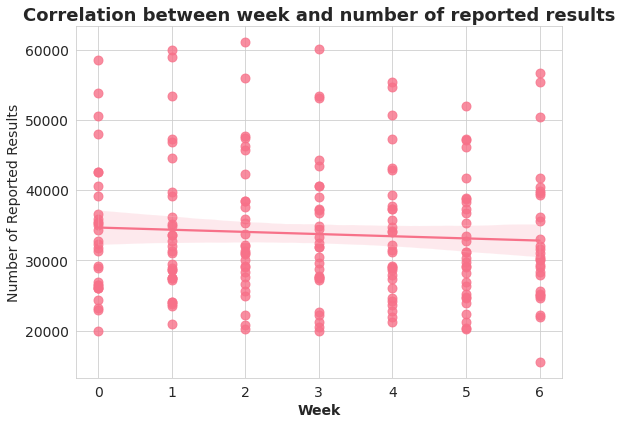

In [28]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("husl")

fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(x='week', y='Number of  reported results', data=df, scatter_kws={"s": 80})
ax.set_xlabel('Week', fontsize=14,fontweight='bold')
ax.set_ylabel('Number of Reported Results', fontsize=14)
ax.set_title('Correlation between week and number of reported results', fontsize=18, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

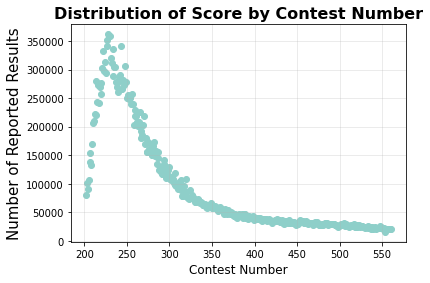

In [26]:
# 绘制散点图
plt.scatter(df['Contest number'], df['Number of  reported results'], color='#8ECFC9')

# 添加图标题和坐标轴标签
plt.title('Distribution of Score by Contest Number', fontsize=16,fontweight='bold')
plt.xlabel('Contest Number', fontsize=12)
plt.ylabel('Number of Reported Results', fontsize=15)

# 设置坐标轴刻度大小
plt.tick_params(axis='both', which='major', labelsize=10)

# 添加网格线
plt.grid(alpha=0.3)

# 显示图形
plt.show()

df['is_weekend'] = df['week'].apply(lambda x:x>4)

/tmp/ipykernel_50158/2708373941.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(df['Contest number'][a:], df['Number of  reported results'][a:])


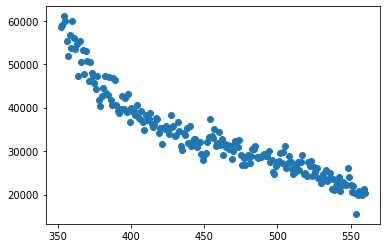

In [12]:
a = 150 # 暂定为150，可以自己设置对应的趋于平稳的阈值
plt.scatter(df['Contest number'][a:], df['Number of  reported results'][a:])
df = df.iloc[a:]

In [28]:
# 提取特征和目标值
features= df[['Contest number']].values
target= df['Number of  reported results'].values
# 数据归一化
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)
target_norm = scaler.fit_transform(target.reshape(-1, 1))

In [29]:

# 初始化模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=9, learning_rate=0.1, subsample=0.8,
                        reg_lambda= 0.5, reg_alpha= 0,gamma= 0, colsample_bytree=0.6,min_child_weight=5)
# 训练模型
model.fit(features_norm, target_norm, eval_set=[(features_norm, target_norm)], early_stopping_rounds=10, verbose=False)

# 预测模型
predictions_norm = model.predict(features_norm)

# 反归一化
predictions = scaler.inverse_transform(predictions_norm.reshape(-1, 1))
target_denorm = scaler.inverse_transform(target_norm.reshape(-1, 1))

/root/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


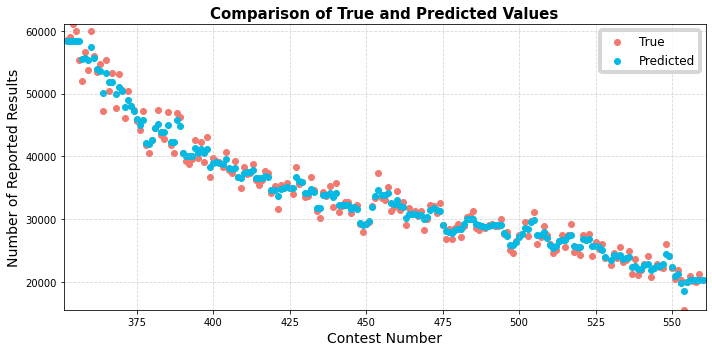

MSE: 1091008.57
MAE: 802.98


In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df["Contest number"], target_denorm, label="True", color='#F27970')
ax.scatter(df["Contest number"], predictions, label="Predicted", color='#05B9E2')
ax.set_xlabel("Contest Number",fontsize=14)
ax.set_ylabel("Number of Reported Results",fontsize=14)
# Add a title to the plot
ax.set_title('Comparison of True and Predicted Values', fontweight='bold',fontsize=15)
# Set the limits of the x-axis and y-axis
ax.set_xlim([df["Contest number"].min()-1, df["Contest number"].max()+1])
ax.set_ylim([min(target_denorm.min(), predictions.min())-1, max(target_denorm.max(), predictions.max())+1])

# Add a legend with increased size, centered, and with a thicker border
legend = ax.legend(loc='upper right', fontsize='large')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_linewidth(4)
ax.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the figure to /root.2023mcm/q1/plot.png
import os
if not os.path.exists('/root.2023mcm/q1'):
    os.makedirs('/root.2023mcm/q1')
plt.savefig('/root.2023mcm/q1/plot.png', bbox_inches='tight')

plt.show()


# 计算评价指标
mse = mean_squared_error(target_denorm, predictions)
mae = mean_absolute_error(target_denorm, predictions)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


In [36]:
history_data= df['Number of  reported results'].iloc[-15:].values
scaler=MinMaxScaler()
history_data=scaler.fit_transform(history_data.reshape(-1,1))

# 定义历史数据的长度
history_length = 15


# 生成新的时间点数据
new_data = np.array([619])

# 构造特征向量
history_data = history_data.reshape(-1, 1)  # 将历史数据的维度转换为 (length, 1)
feature_vector = []
feature_vector.append(history_data)

new_data_vector = new_data.reshape(-1, 1)  # 将新的时间点数据的维度转换为 (1, 1)
feature_vector.append(new_data_vector)

# 对特征向量进行预处理
dtest = np.concatenate(feature_vector, axis=0)

# 使用XGBoost模型对新的时间点数据进行预测
y_pred = model.predict(dtest)
y_pred=scaler.inverse_transform(y_pred.reshape(1,-1))
# 计算预测结果的取值范围和置信度分析
prediction_range = (np.min(y_pred), np.max(y_pred))
prediction_confidence = np.std(y_pred)
prediction_range


(16645.494, 25407.666)

In [17]:
from scipy.stats import norm
# 进行bootstrapping，假设采样次数为B=1000
B = 1000
y_pred=y_pred.squeeze()
n = len(y_pred)
y_pred_resample = np.zeros((B, n))
for i in range(B):
    idx = np.random.choice(n, n, replace=True)
    y_pred_resample[i] = y_pred[idx]

# 计算置信区间，假设置信水平为1-alpha=0.95
alpha = 0.05
y_pred_mean = np.mean(y_pred)
y_pred_std = np.mean(np.std(y_pred_resample, axis=1, ddof=1))
z_alpha_2 = norm.ppf(1-alpha/2)
lower_bound = y_pred_mean - z_alpha_2*y_pred_std/np.sqrt(n)
upper_bound = y_pred_mean + z_alpha_2*y_pred_std/np.sqrt(n)

# 输出置信区间
print("95% Confidence Interval: [{:.2f}, {:.2f}]".format(lower_bound, upper_bound))
    


95% Confidence Interval: [18289.66, 19917.65]


In [18]:
y_pred_mean

19103.656

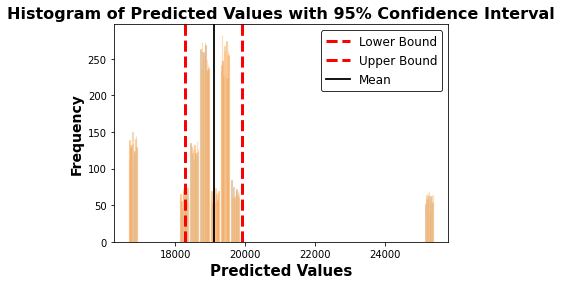

In [19]:
import matplotlib.pyplot as plt

#修改图像背景颜色
plt.style.use('tableau-colorblind10')

#绘制数据直方图
plt.hist(y_pred_resample, bins=30, alpha=0.5, edgecolor='#FFBE7A', linewidth=1.2)
plt.axvline(lower_bound, color='r', linestyle='--', linewidth=3, label='Lower Bound')
plt.axvline(upper_bound, color='r', linestyle='--', linewidth=3, label='Upper Bound')
plt.axvline(y_pred_mean, color='k', linestyle='-', linewidth=1.8, label='Mean')
plt.xlabel('Predicted Values', fontsize=15, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Histogram of Predicted Values with 95% Confidence Interval', fontsize=16, fontweight='bold')

#增加图例
# 给图例加上边框
plt.legend(fontsize=12, loc='upper right', frameon=True, 
           facecolor='white', edgecolor='black')


#显示图像
plt.show()

ValueError: x and y must have same first dimension, but have shapes (101,) and (208,)

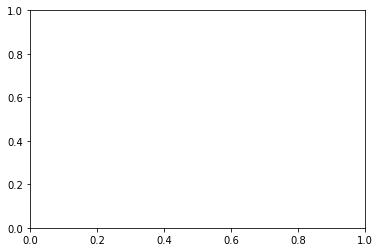

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 进行 bootstrapping，假设采样次数为 B=1000
B = 1000
y_pred = predictions.squeeze()
n = len(y_pred)
y_pred_resample = np.zeros((B, n))
for i in range(B):
    idx = np.random.choice(n, n, replace=True)
    y_pred_resample[i] = y_pred[idx]

# 计算置信区间和预测区间，假设置信水平为 1-alpha1=0.95，预测水平为 1-alpha2=0.95
alpha1 = 0.05
alpha2 = 0.05
y_pred_mean = np.mean(y_pred)
y_pred_std = np.mean(np.std(y_pred_resample, axis=1, ddof=1))
z_alpha_1_2 = norm.ppf(1-alpha1/2)
z_alpha_2_2 = norm.ppf(1-alpha2/2)
lower_bound_1 = y_pred_mean - z_alpha_1_2*y_pred_std/np.sqrt(n)
upper_bound_1 = y_pred_mean + z_alpha_1_2*y_pred_std/np.sqrt(n)
lower_bound_2 = y_pred_mean - z_alpha_2_2*y_pred_std/np.sqrt(n)
upper_bound_2 = y_pred_mean + z_alpha_2_2*y_pred_std/np.sqrt(n)

# 计算 Contest Number-y 曲线上的点
x = np.linspace(0, 100, 101)
y = y_pred

# 绘制 Contest Number-y 曲线和置信带
plt.plot(x, y, color='blue', label='Model Predictions')
plt.fill_between(x, lower_bound_1, upper_bound_1, color='gray', alpha=0.2, label='95% Confidence Interval')

# 计算预测带上的点
x_new = np.linspace(101, 200, 100)
y_new =y_pred

# 计算预测带的上下界
std_err = y_pred_std*np.sqrt(1 + 1/n + (x_new-np.mean(x))**2/np.sum((x-np.mean(x))**2))
lower_bound_3 = y_new - z_alpha_2_2*std_err
upper_bound_3 = y_new + z_alpha_2_2*std_err

# 绘制预测带
plt.fill_between(x_new, lower_bound_3, upper_bound_3, color='lightblue', alpha=0.2, label='95% Prediction Interval')

# 添加图例和标题
plt.legend(loc='upper left')
plt.xlabel('Contest Number')
plt.ylabel('y')
plt.title('Contest Number-y Curve with 95% Confidence and Prediction Bands')

# 显示图形
plt.show()